In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
sns.set(style="ticks")
plt.style.use(u'ggplot')
%matplotlib inline
sys.path.append("/Users/pubudu/Documents/MyGithub/my_modules/")
import ecdf, ffind, fgenes

In [2]:
def split_regions(r):
    g = r.split(" ")[0]
    gSplit = g.split(":")
    chrom = gSplit[0]#"chr{}".format(gSplit[0])
    start, end = gSplit[1].split("-")
    return chrom, int(start), int(end)

def sig_test(r):
    ret_str = "not_significant"
    if r <= 0.1:
        ret_str = "significant"
    return ret_str

# Format Genomic HyperBrowser output
def format_HBFile(hb_file_in, col_id):
    hb_file = pd.read_table(hb_file_in, skiprows=2)
    print ("Columns and their data typs of the input file:")
    print (hb_file.dtypes)
    hb_file.columns = ['Region', 'P-value', 'FDR-adjusted p-values', 'Test statistic: Observed base pair overlap', 'Mean of null distribution', 'Median of null distribution', 'Standard deviation of null distribution', 'Difference from mean', 'Number of Monte Carlo samples', 'Number of Monte Carlo samples (excluding any NaN samples)', 'Number of Monte Carlo samples with extreme test statistic', 'Number of elements in query', 'Number of elements in IMR90TADs', 'Assembly gap coverage']
    hb_file.columns = hb_file.columns.str.lower().str.replace(' ', '_')
    print ("\n\nNumber of null values in fdr-adjusted_p-values: {}".format(len(hb_file[hb_file['fdr-adjusted_p-values'].isnull()]) ))
    print ("Removing rows with null values in fdr-adjusted_p-values...\n")
    hb_file = hb_file[hb_file['fdr-adjusted_p-values'].notnull()].reset_index().drop('index', axis=1)
    #print ("Null values in columns...")
    #print (hb_file.isnull().sum())
    
    hb_file_out = pd.DataFrame()
    hb_file_out = hb_file[['region', 'fdr-adjusted_p-values', 'test_statistic:_observed_base_pair_overlap', 'difference_from_mean', 'number_of_elements_in_query', 'number_of_elements_in_imr90tads' ]].copy()
    hb_file_out.columns = ['region', 'p-values_adj', 'test_statistic', 'diff_from_mean', 'elements_in_query', 'number_of_TADs' ]
    hb_file_out = hb_file_out[~hb_file_out['region'].str.contains("intersect")]
    hb_file_out['chr'], hb_file_out['start'], hb_file_out['end'] = zip(*hb_file_out.apply(lambda x: split_regions(x['region']), axis=1 ))
    hb_file_out = hb_file_out[['chr', 'start', 'end', 'p-values_adj', 'test_statistic', 'diff_from_mean', 'elements_in_query', 'number_of_TADs' ]]
    if hb_file_out['test_statistic'].dtype==object:
        hb_file_out['test_statistic'] = hb_file_out['test_statistic'].apply(lambda x: x.replace(" ",""))
        hb_file_out['diff_from_mean'] = hb_file_out['diff_from_mean'].apply(lambda x: x.replace(" ",""))
    hb_file_out[['test_statistic','diff_from_mean']] = hb_file_out[['test_statistic','diff_from_mean']].astype(float)
    hb_file_out[['elements_in_query', 'number_of_TADs']] = hb_file_out[['elements_in_query', 'number_of_TADs']].astype(int)
    #hb_file_out['log2_test_statistic'] = hb_file_out['test_statistic'].apply(lambda x: np.log2(x))
    hb_file_out['Cancer_type'] = col_id
    hb_file_out['Signif'] = hb_file_out['p-values_adj'].apply(lambda x: sig_test(x))
    
    print ("\n Length of output dataframe: {}".format(len(hb_file_out)))
    print ("\n Number of significant bins: {}".format(len(hb_file_out[hb_file_out['Signif'] == 'significant'])))
    print ("\n Output file:")
    print (hb_file_out.info())

    return hb_file_out

In [3]:
c_ID = "SKCM"
cns_type = 'amps'

### 3D hotspots in recurrent deletions

In [4]:
hb = ffind.find("HyperBrowser___Located_nearby___on__*_breakpoints_in_GAIA-GISTIC2-intersect_{}_0119_hbinput.bed_*__vs__IMR90.domainList.chr.sorted.merged_table.txt".format(cns_type), "../01.SKCM/datasets_0119/0.breakpoints")
if len(hb) == 1:
    hb = hb[0]
    print (hb)
else:
    print (f"Error: check HB file in datasets_0119 \n {hb}")

/Users/pubudu/Documents/SCAN-hic/V04-012019/demo/../01.SKCM/datasets_0119/0.breakpoints/HyperBrowser___Located_nearby___on__01.SKCM_breakpoints_in_GAIA-GISTIC2-intersect_amps_0119_hbinput.bed_(3)__vs__IMR90.domainList.chr.sorted.merged_table.txt


In [5]:
hb_df = format_HBFile(hb, c_ID)
hb_df.head()

Columns and their data typs of the input file:
#Region                                                                                         object
P-value                                                                                         object
FDR-adjusted p-values                                                                          float64
Test statistic: Average log-distance                                                            object
Mean of null distribution                                                                       object
Median of null distribution                                                                     object
Standard deviation of null distribution                                                         object
Difference from mean                                                                            object
Number of Monte Carlo samples                                                                   object
Number of Monte Carlo samp

,chr,start,end,p-values_adj,test_statistic,diff_from_mean,elements_in_query,number_of_TADs,Cancer_type,Signif
0,chr1,149000002,152000001,0.006372,1.3910,-3.06400,70,4,SKCM,significant
1,chr1,152000002,153000001,0.941800,0.1855,-0.03451,39,3,SKCM,not_significant
2,chr1,153000002,157000001,0.487700,1.3280,-0.48200,80,12,SKCM,not_significant
3,chr1,157000002,161000001,0.989300,3.8480,1.16600,96,8,SKCM,not_significant
4,chr1,161000002,163000001,0.354000,1.4520,-0.87440,51,6,SKCM,not_significant


In [6]:
#??ecdf.ecdf

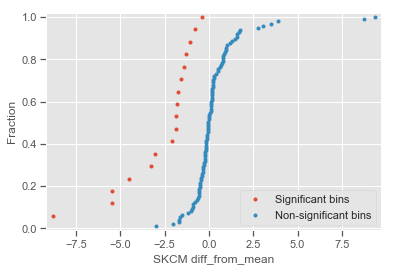

In [7]:
x_signif, y_signif = ecdf.ecdf(hb_df[hb_df['Signif'] == 'significant']['diff_from_mean'].values)
x_nonsignif, y_nonsignif = ecdf.ecdf(hb_df[hb_df['Signif'] == 'not_significant']['diff_from_mean'].values)
plt.plot(x_signif, y_signif, marker = '.', linestyle = 'none')
plt.plot(x_nonsignif, y_nonsignif, marker = '.', linestyle = 'none')

# Make the margins nice
plt.margins(0.02)

# Label the axes
plt.xlabel("SKCM diff_from_mean")
plt.ylabel('Fraction')
plt.legend(('Significant bins', 'Non-significant bins'), loc='lower right')

# Display the plot
plt.show()

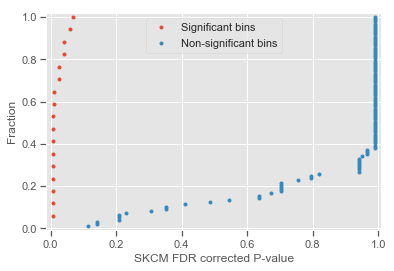

In [8]:
x_signif, y_signif = ecdf.ecdf(hb_df[hb_df['Signif'] == 'significant']['p-values_adj'].values)
x_nonsignif, y_nonsignif = ecdf.ecdf(hb_df[hb_df['Signif'] == 'not_significant']['p-values_adj'].values)
plt.plot(x_signif, y_signif, marker = '.', linestyle = 'none')
plt.plot(x_nonsignif, y_nonsignif, marker = '.', linestyle = 'none')

# Make the margins nice
plt.margins(0.02)

# Label the axes
plt.xlabel("SKCM FDR corrected P-value")
plt.ylabel('Fraction')
plt.legend(('Significant bins', 'Non-significant bins'), loc='upper center')

# Display the plot
plt.show()

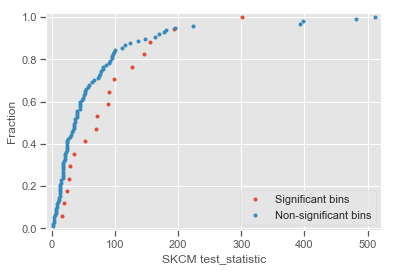

In [9]:
#plt.figure(figsize=(12,4))
x_signif, y_signif = ecdf.ecdf(hb_df[hb_df['Signif'] == 'significant']['elements_in_query'].values)
x_nonsignif, y_nonsignif = ecdf.ecdf(hb_df[hb_df['Signif'] == 'not_significant']['elements_in_query'].values)
plt.plot(x_signif, y_signif, marker = '.', linestyle = 'none')
plt.plot(x_nonsignif, y_nonsignif, marker = '.', linestyle = 'none')

# Make the margins nice
plt.margins(0.02)

# Label the axes
plt.xlabel("SKCM test_statistic")
plt.ylabel('Fraction')
plt.legend(('Significant bins', 'Non-significant bins'), loc='lower right')

# Display the plot
plt.show()

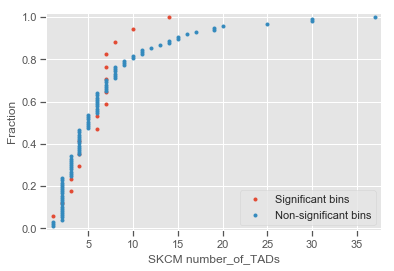

In [10]:
#plt.figure(figsize=(12,4))
x_signif, y_signif = ecdf.ecdf(hb_df[hb_df['Signif'] == 'significant']['number_of_TADs'].values)
x_nonsignif, y_nonsignif = ecdf.ecdf(hb_df[hb_df['Signif'] == 'not_significant']['number_of_TADs'].values)
plt.plot(x_signif, y_signif, marker = '.', linestyle = 'none')
plt.plot(x_nonsignif, y_nonsignif, marker = '.', linestyle = 'none')

# Make the margins nice
plt.margins(0.02)

# Label the axes
plt.xlabel("SKCM number_of_TADs")
plt.ylabel('Fraction')
plt.legend(('Significant bins', 'Non-significant bins'), loc='lower right')

# Display the plot
plt.show()

### 1.1 Identify TAD hotspots

In [11]:
hb_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 114 entries, 0 to 115
Data columns (total 10 columns):
chr                  114 non-null object
start                114 non-null int64
end                  114 non-null int64
p-values_adj         114 non-null float64
test_statistic       114 non-null float64
diff_from_mean       114 non-null float64
elements_in_query    114 non-null int64
number_of_TADs       114 non-null int64
Cancer_type          114 non-null object
Signif               114 non-null object
dtypes: float64(3), int64(4), object(3)
memory usage: 9.8+ KB


In [12]:
sig_ab_comps = "{}/{}_{}_{}_{}.txt".format('datasets_0119/0.breakpoints', '02', c_ID, cns_type, 'sig_ab_comps')
print (sig_ab_comps)

datasets_0119/0.breakpoints/02_SKCM_amps_sig_ab_comps.txt


In [13]:
hb_df[hb_df['Signif'] == 'significant'][['chr', 'start', 'end', 'Signif']].drop_duplicates().to_csv(sig_ab_comps, sep="\t", index=False)

In [14]:
recurrent_bps = ffind.find("01.{}_breakpoints_in_GAIA-GISTIC2-intersect_{}_0119.bed".format(c_ID, cns_type), "../01.SKCM/datasets_0119/0.breakpoints")
if len(recurrent_bps) == 1:
    recurrent_bps = recurrent_bps[0]
    print (recurrent_bps)
else:
    print ("Error: check breakpoints_in_GAIA-GISTIC2-intersect_amps file in datasets_0618")

/Users/pubudu/Documents/SCAN-hic/V04-012019/demo/../01.SKCM/datasets_0119/0.breakpoints/01.SKCM_breakpoints_in_GAIA-GISTIC2-intersect_amps_0119.bed


In [15]:
bp_3D_sig = f"datasets_0119/0.breakpoints/02.{c_ID}_{cns_type}_GISTIC2-GAIA-recurrent.breakpoints_in_sigABComps.bed" #"datasets_0119/0.breakpoints/02.{}_{}_GISTIC2-GAIA-significant.breakpoints.bed".format(c_ID, cns_type)
print (bp_3D_sig)

datasets_0119/0.breakpoints/02.SKCM_amps_GISTIC2-GAIA-recurrent.breakpoints_in_sigABComps.bed


In [16]:
%%bash -s $sig_ab_comps $recurrent_bps $bp_3D_sig
echo $3
intersectBed -a $2 -b $1 -f 0.9 -u | sortBed -i stdin > $3
wc -l $3

datasets_0119/0.breakpoints/02.SKCM_amps_GISTIC2-GAIA-recurrent.breakpoints_in_sigABComps.bed
    2249 datasets_0119/0.breakpoints/02.SKCM_amps_GISTIC2-GAIA-recurrent.breakpoints_in_sigABComps.bed
